In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import skimage 
from skimage import io, filters

In [52]:
#fname = "/Users/timrudge/RaspiScope/Timelapse060117/image_%04d.jpg"
#fname = "/Users/timrudge/RaspiScope/timelapse/timlap_3_%04d.jpg"
fname =  "/Users/timrudge/RaspiScope/Lab_19_1_17/image_%04d.jpg"
fname%(0)

'/Users/timrudge/RaspiScope/Lab_19_1_17/image_0000.jpg'

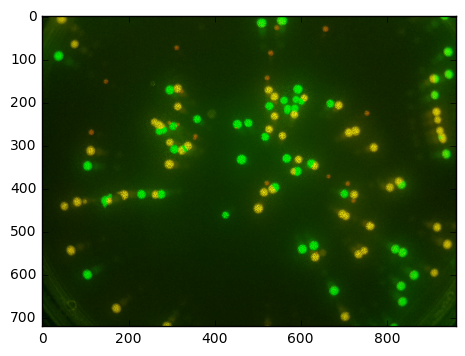

In [53]:
im = plt.imread(fname%500)
plt.imshow(im)

In [54]:
im.shape
w,h,_ = im.shape

In [55]:
nt = 552
ims = np.zeros((w,h,nt))
for i in range(nt):
    im = plt.imread(fname%i)
    ims[:,:,i] = im[:,:,1]

In [56]:
ims.shape

(720, 960, 552)

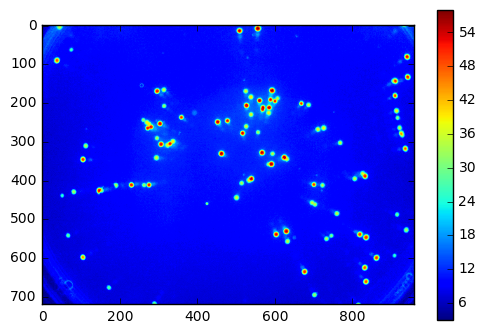

In [57]:
plt.imshow(ims[:,:,0])
plt.colorbar()
imssub = ims[200:600,200:600,:]
plt.imshow(ims[:,:,-200])

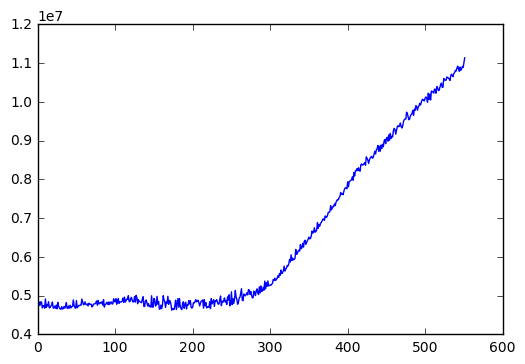

In [58]:
sumims = imssub.sum(axis=(0,1))
sumims.shape
plt.plot(sumims)

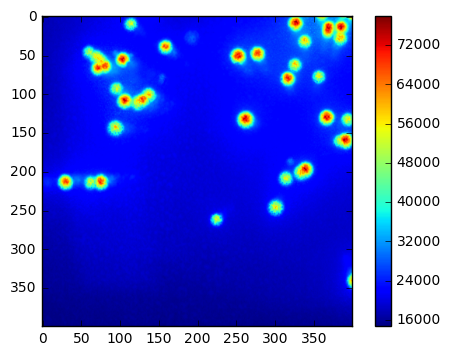

In [59]:
ims_sum = imssub.sum(axis=2)
plt.imshow(ims_sum)
plt.colorbar()

In [60]:
from skimage.filters import gaussian
simsub = gaussian(ims_sum, 2)
nsimsub = (simsub-simsub.min())/(simsub.max()-simsub.min())

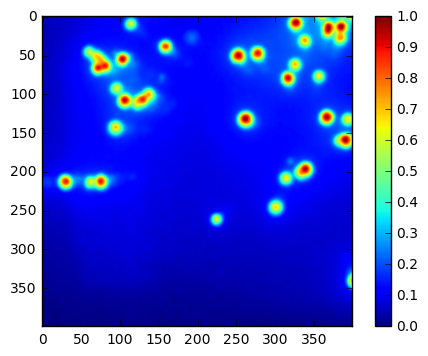

In [61]:
plt.imshow(nsimsub)
plt.colorbar()

In [62]:
import skimage.feature as skfeat
A = skfeat.blob_log(nsimsub, min_sigma=1.0, max_sigma=10.0, num_sigma=100, threshold=0.25, overlap=0.8)

In [63]:
A.shape
#A[1:10,:]

(22, 3)

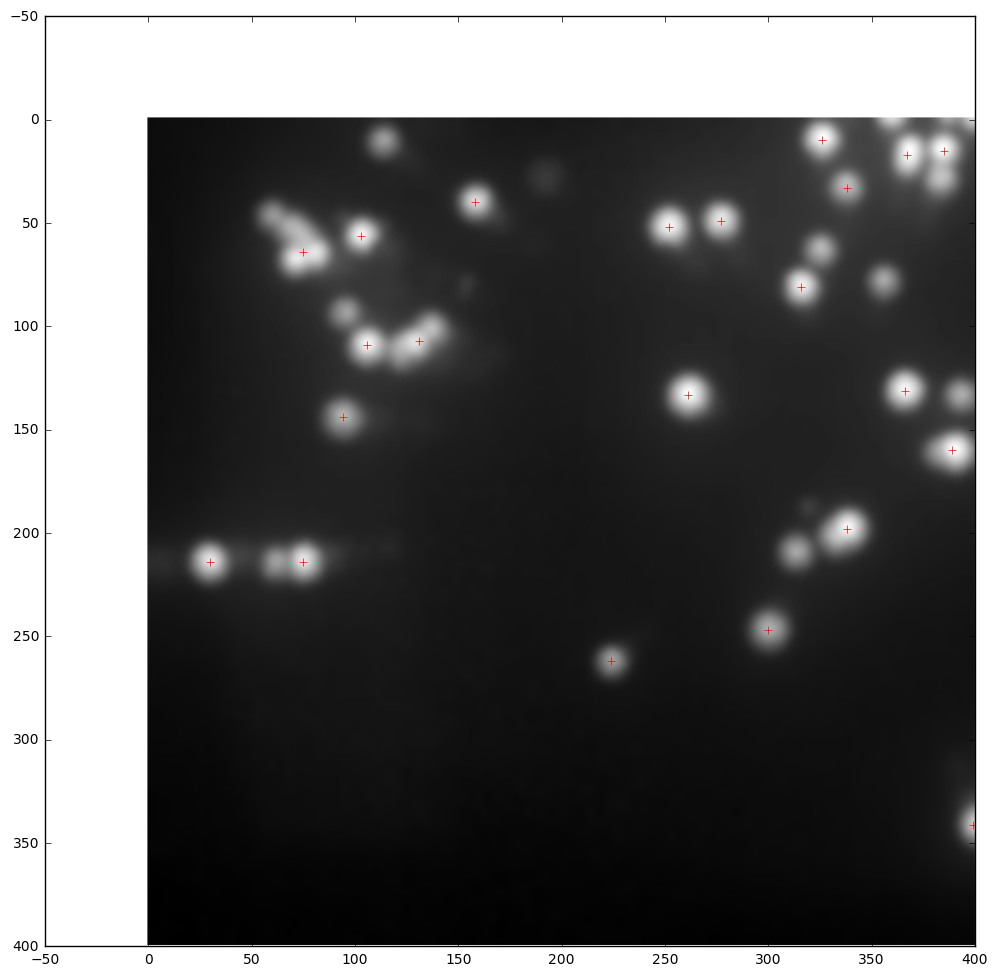

In [64]:
plt.figure(figsize=(16,12))
plt.imshow(nsimsub, cmap='gray')
plt.hold(True)
for i in range(len(A)):
    plt.plot(A[i,1],A[i,0],'r+')

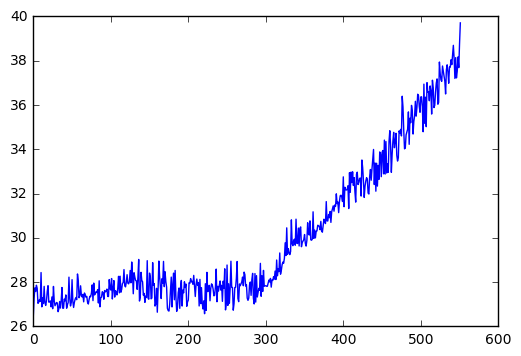

In [181]:
bg = imssub[300:400,0:100,:].mean(axis=(0,1))
plt.plot(bg)

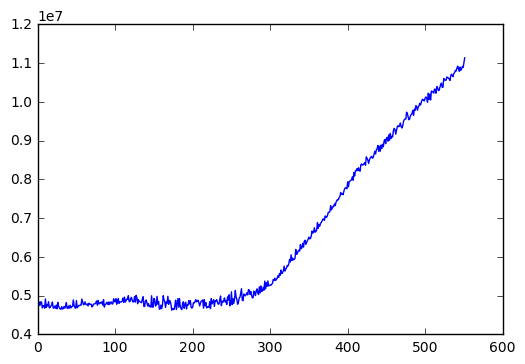

In [85]:
plt.plot(imssub.sum(axis=(0,1)))

In [175]:
rois = {}
for i in range(len(A)):
    x = A[i,0]
    y = A[i,1]
    r = 2*A[i,2]
    rois[i] = imssub[x-r:x+r,y-r:y+r,:]-bg

/Users/timrudge/miniconda/envs/raspiscope/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


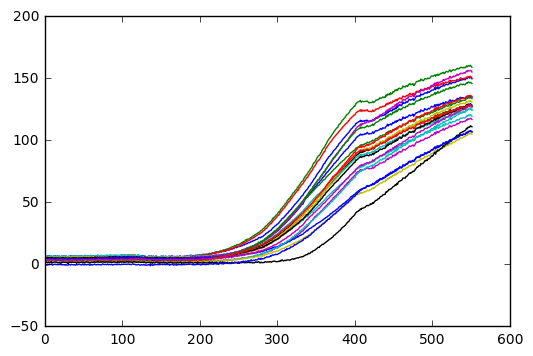

In [183]:
for i in range(len(A)):
    plt.plot(rois[i].mean(axis=(0,1)))
    plt.hold(True)

In [177]:
R = {}
for k in range(len(A)):
    R[k] = np.zeros((nt,))
    for i in range(nt):
        troi = rois[k][:,:,i].astype(np.float32)
        ntroi = (troi-troi.min())/(troi.max()-troi.min())
        AA = skfeat.blob_log(ntroi, min_sigma=1.0, max_sigma=10.0, num_sigma=200, threshold=0.25, overlap=0.8)
        if len(AA)>0:
            R[k][i] = AA[0,2]
'''
print AA
plt.imshow(roi200, interpolation='none')
plt.figure()
plt.plot(roi200[7,:])
'''
#plt.plot(R[3]*R[3], rois[3].sum(axis=(0,1)), '.')

"\nprint AA\nplt.imshow(roi200, interpolation='none')\nplt.figure()\nplt.plot(roi200[7,:])\n"

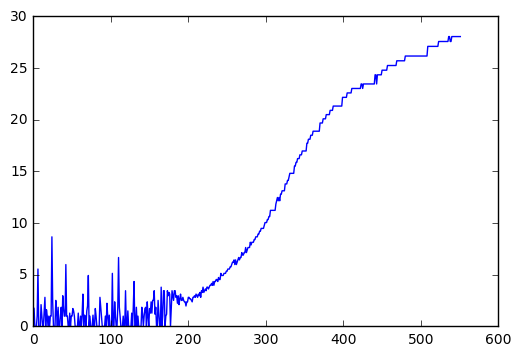

In [178]:
idx = [0]
for i in idx:
    r = R[i][0:]
    plt.plot(r*r)
    plt.hold(True)

(20, 21, 552)

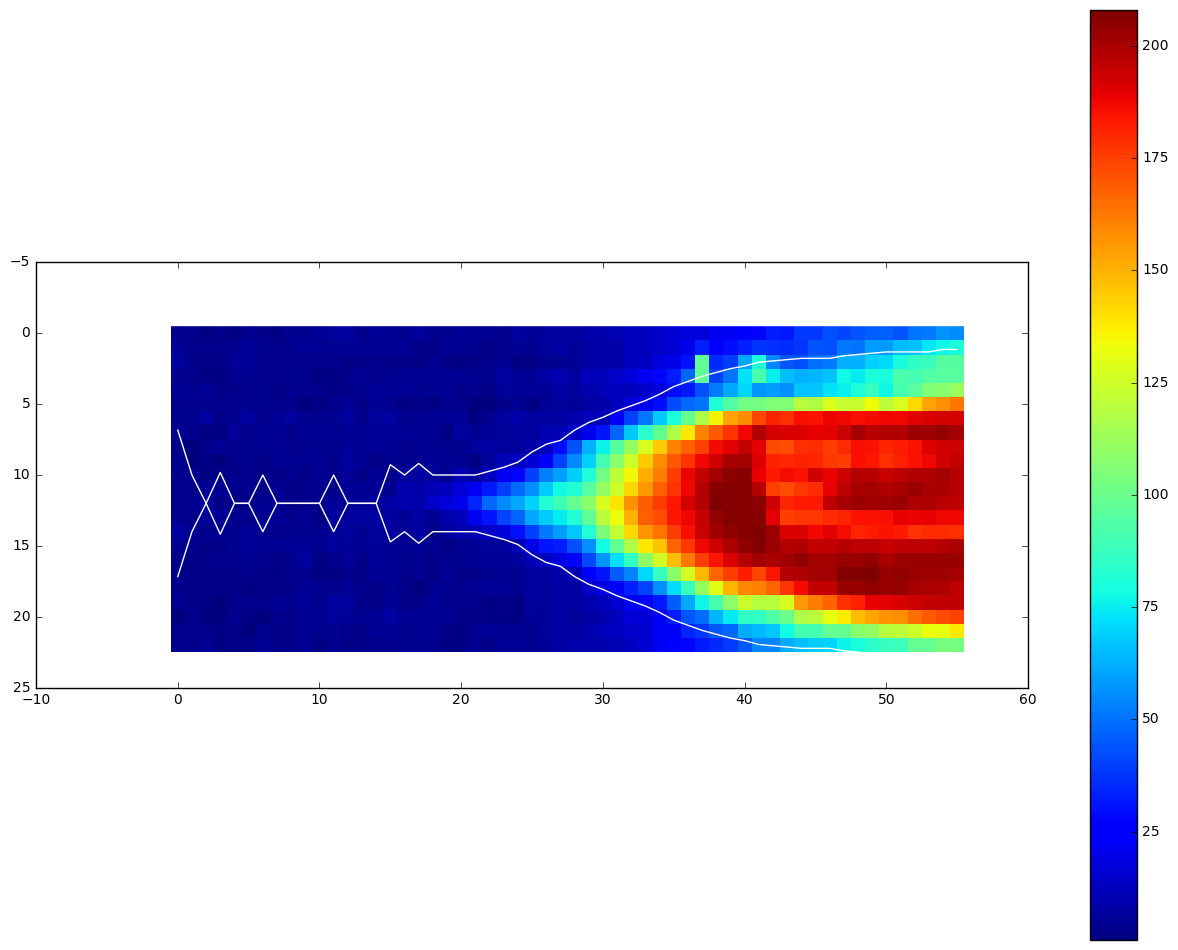

In [206]:
idx = 9
plt.figure(figsize=(16,12))
w,h,d = rois[idx].shape
plt.imshow(rois[idx][w/2+1,:,0:-1:10], interpolation='none', cmap='')
plt.colorbar()
plt.hold(True)
plt.plot(-R[idx][0:-1:10]*2+h/2+1,'w')
plt.plot(R[idx][0:-1:10]*2+h/2+1,'w')
rois[0].shape

In [133]:
%matplotlib auto
for i in range(300,400):
    plt.imshow(rois[0][:,:,i], interpolation='none')
    plt.title('%f'%R[0][i])
    plt.pause(0.1)
%matplotlib inline

Using matplotlib backend: MacOSX


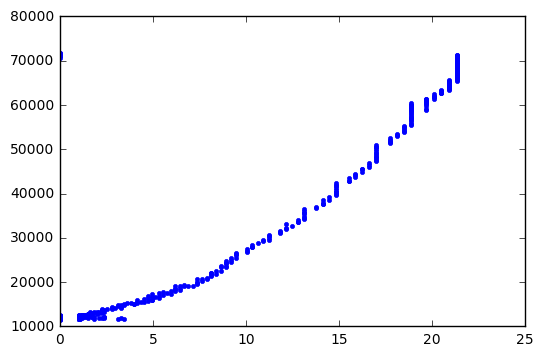

In [134]:
plt.plot(R[1]*R[1], rois[1].sum(axis=(0,1)), '.')

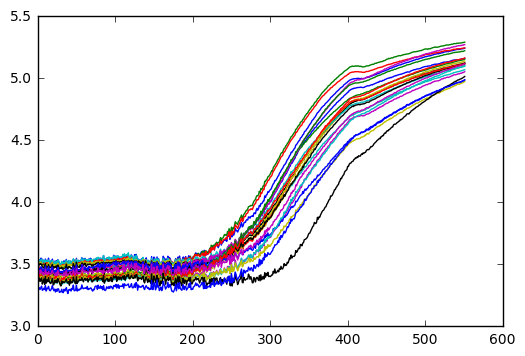

In [135]:
for i in range(len(A)):
    roi = rois[i]
    plt.plot(np.log(roi.mean(axis=(0,1))))
    plt.hold(True)
plt.legend()

In [ ]:
plt.plot(ims[500,200,:])

In [ ]:
plt.figure(figsize=(16,12))
plt.imshow(ims[A[10,0],400:450,:])

In [ ]:
s = np.diff(ims[A[10,0],:,:], axis=1)
s.shape

In [ ]:
c=np.cov(s)
x = A[10,0]
y = A[10,1]
plt.plot(c[y,y-20:y+20])
c[y,y]